# Load data

In [1]:
# We use as few libraries as possible to make the code more portable, and to make it easier to understand.
# I.e., there are fewer libraries to learn.

import torch
import pandas as pd
%matplotlib inline

import os
import pathlib

In [2]:
# A few convenience functions for manipulating data and plotting

from iterativennsimple.utils.df_to_tensor import df_to_tensor
from iterativennsimple.utils.StartTargetData import StartTargetData
from iterativennsimple.utils.plot_2D_start_end import plot_2D_start_end

In [3]:
# Select the problem of interest here.  There are the problems for which this notebook is set up, namely the simple 1D input and 1D output problems.

name = 'regression_line'
#name = 'pca_line'
#name = 'circle'
#name = 'regression_circle'

# The directory in which the notebook is located.
base_dir = pathlib.Path(os.path.dirname(os.path.realpath(__file__)))
# The directory where the data is stored.
data_dir = base_dir / '../data/processed'

# Read the start data
z_start = pd.read_parquet(data_dir / f'{name}_start.parquet')
# Read the target data
z_target = pd.read_parquet(data_dir / f'{name}_target.parquet')


# Neural network

Here we have our dynamical system/neural network.  This is a simple dense network that attempts to map the start data to the target data.  I.e., it trys to learn the dynamics of the system.

Note, the same network structure is used for all the problems, but the weights will be trained for each problem.

In [4]:
z_size = z_start.shape[1]
# This value is chosen to work well for the problems we consider here, but can definitely be changed.
# Experimenting with this value is a good idea, and a great place to start when trying to improve the performance of the model.
hidden_size = 20
map = torch.nn.Sequential(torch.nn.Linear(z_size, hidden_size),
                          torch.nn.ReLU(), 
                          torch.nn.Linear(hidden_size, hidden_size), 
                          torch.nn.ReLU(), 
                          torch.nn.Linear(hidden_size, hidden_size), 
                          torch.nn.ReLU(), 
                          torch.nn.Linear(hidden_size, z_size))

In [5]:


# Make two pytorch tensor datasets from the start and target data
z_start_tensor = df_to_tensor(z_start)
z_target_tensor = df_to_tensor(z_target)
    
train_data = StartTargetData(z_start_tensor, z_target_tensor)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=100, shuffle=True)

In [6]:
# Define the loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(map.parameters(), lr=0.001)

In [7]:
max_epochs = 500
# Train the model
for epoch in range(max_epochs):
    for batch_idx, (start, target) in enumerate(train_loader):
        optimizer.zero_grad()
        mapped = map(start)
        loss = criterion(mapped, target)
        loss.backward()
        optimizer.step()
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Batch {batch_idx}, Loss {loss.item()}')

Epoch 0, Batch 9, Loss 0.11284946650266647
Epoch 100, Batch 9, Loss 9.854673407971859e-06
Epoch 200, Batch 9, Loss 2.579911097200238e-06
Epoch 300, Batch 9, Loss 4.582435408906349e-08
Epoch 400, Batch 9, Loss 1.593912735131653e-08


# Training data

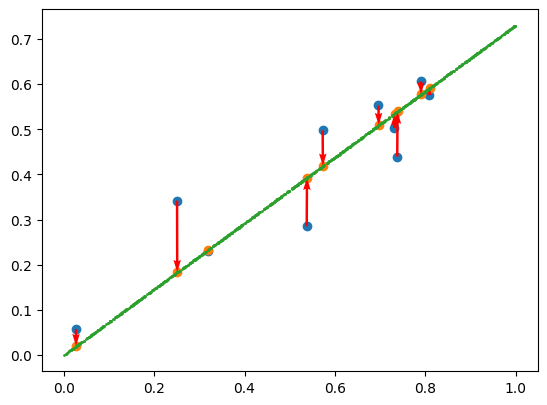

In [8]:
mapped_tensor = map(z_start_tensor).detach()
plot_2D_start_end(z_start_tensor[:,0], z_start_tensor[:,1],
                  mapped_tensor[:,0], mapped_tensor[:,1], 
                  z_target_tensor[:,0], z_target_tensor[:,1])

# Testing data

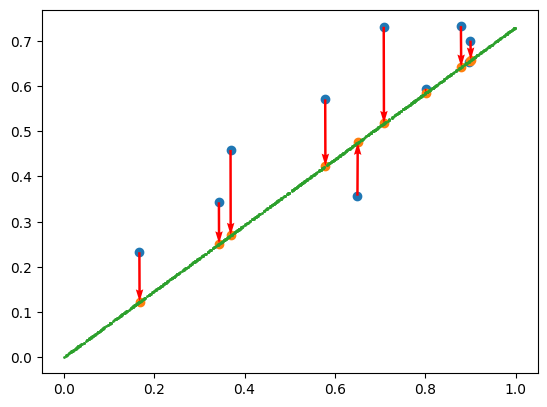

In [9]:
z_start_tensor_test = z_start_tensor+torch.rand_like(z_start_tensor)*0.2
mapped_tensor = map(z_start_tensor_test).detach()
plot_2D_start_end(z_start_tensor_test[:,0], z_start_tensor_test[:,1],
                  mapped_tensor[:,0], mapped_tensor[:,1], 
                  z_target_tensor[:,0], z_target_tensor[:,1])